In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor']='w'

In [27]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage

In [46]:
teledf = pd.read_csv('teledf.csv').drop(columns=['Unnamed: 0'])
teledf_all=pd.read_csv('teledf_all.csv').drop(columns=['Unnamed: 0'])
teledf_bins=pd.read_csv('teledf_bins.csv').drop(columns=['Unnamed: 0'])
teledf_churn=pd.read_csv('teledf_churn.csv').drop(columns=['Unnamed: 0'])
teledf_nochurn=pd.read_csv('teledf_nochurn.csv').drop(columns=['Unnamed: 0'])

In [47]:
teledf_all.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Bin_Total night calls,Bin_Total night charge,Bin_Total intl minutes,Bin_Total intl calls,Bin_Total intl charge,Bin_Total minutes,Bin_Total calls,Bin_Total charge,Bin_Account length,Bin_Number vmail messages
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,...,2,2,2,0,2,3,2,3,2,2
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,...,2,3,3,0,3,2,3,2,2,2
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,...,2,1,3,1,3,2,3,2,2,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,...,1,2,1,1,1,2,1,2,1,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,...,3,2,2,0,2,1,3,1,1,0


In [54]:
X = teledf.drop(columns = ['State'])
# X = teledf_bins.drop(columns = ['State'])
# X = teledf_churn.drop(columns = ['State'])
# X = teledf_nochurn.drop(columns = ['State'])

#in data prep, minmaxscaler yielded much better results than standardscaler
scaler = MinMaxScaler()
pca_test = PCA()

X_scaled = scaler.fit_transform(X)
X_scaled_pca_test = pca_test.fit_transform(X_scaled)

In [55]:
#pca components testing

pca_test.n_components_

22

(0, 1)

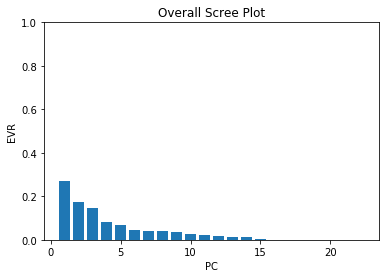

In [56]:
#scree plot
plt.bar(range(1,23),pca_test.explained_variance_ratio_)
plt.title('Overall Scree Plot')
plt.xlabel('PC')
plt.ylabel('EVR')
plt.ylim(0,1)

(0, 1)

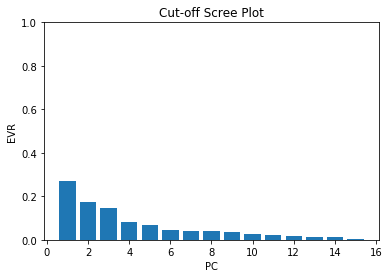

In [57]:
plt.bar(range(1,16),pca_test.explained_variance_ratio_[:15])
plt.title('Cut-off Scree Plot')
plt.xlabel('PC')
plt.ylabel('EVR')
plt.ylim(0,1)

# pca n_components = 3

In [58]:
#implementing pca

pca = PCA(n_components=3)
X_scaled_pca = pca.fit_transform(X_scaled)

In [59]:
#kmeans testing K value


inertias_list = []
sil_list = []

for i in range(1,10):
    kmeans_1 = KMeans(n_clusters=i, random_state = 42)
    kmeans_1.fit(X_scaled_pca)
    inertias_list.append(kmeans_1.inertia_)
    try:
        sil_list.append(silhouette_score(X_scaled, kmeans_1.labels_))
    except ValueError:
        sil_list.append(np.nan)

Text(0.5, 1.0, 'Inertia plot')

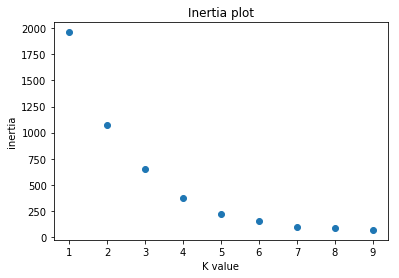

In [60]:
plt.scatter(range(1,10),inertias_list)
plt.xlabel('K value')
plt.ylabel('inertia')
plt.title('Inertia plot')

Text(0.5, 1.0, 'Silhouette plot')

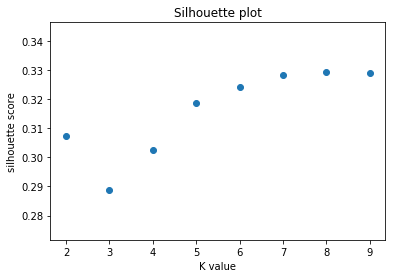

In [61]:
plt.scatter(range(1,10),sil_list)
plt.xlabel('K value')
plt.ylabel('silhouette score')
plt.title('Silhouette plot')

In [63]:
# optimal K value is 8

kmeans_final = KMeans(n_clusters = 2)

In [70]:
# testing DBSCAN

metrics_range = ['euclidean', 'manhattan', 'cosine']
samples_range = range(1,10)
eps_range = np.arange(0.1,1,0.1)

sil2_list = []

for i in metrics_range:
    for j in samples_range:
        for k in eps_range:
            dbloop = DBSCAN(metric=i, min_samples=j, eps=k)
            dbloop.fit(X_scaled_pca)
            cluster_index_loop = np.where(dbloop.labels_ != -1)[0]
            try:
                sil2_list.append((i,j,k,silhouette_score(X_scaled[cluster_index_loop], dbloop.labels_[cluster_index_loop], metric = i)))
            except ValueError:
                sil2_list.append(np.nan)

In [71]:
scoredf = pd.DataFrame(sil2_list, columns = ['metric','min_samples','eps','score'])

In [82]:
scoredf[scoredf.groupby(['metric'])['score'].transform(max) == scoredf['score']].head()

,metric,min_samples,eps,score
72,euclidean,9.0,0.1,0.333489
83,manhattan,1.0,0.3,0.233546
84,manhattan,1.0,0.4,0.233546
85,manhattan,1.0,0.5,0.233546
86,manhattan,1.0,0.6,0.233546


In [74]:
#test lower eps and higher min_samples for euclidean

samples_range2 = range(9,20)
eps_range2 = np.arange(0.01,0.11,0.01)
sil3_list = []

for j in samples_range2:
    for k in eps_range2:
        dbloop2 = DBSCAN(metric='euclidean', min_samples=j, eps=k)
        dbloop2.fit(X_scaled_pca)
        cluster_index_loop = np.where(dbloop2.labels_ != -1)[0]
        try:
            sil3_list.append((j,k,silhouette_score(X_scaled[cluster_index_loop], dbloop2.labels_[cluster_index_loop], metric = 'euclidean')))
        except ValueError:
            sil3_list.append(np.nan)

In [81]:
scoredf2 = pd.DataFrame(sil3_list, columns = ['min_samples','eps','score'])
scoredf2.sort_values(by='score', ascending=False).head()

,min_samples,eps,score
95,18,0.06,0.363641
105,19,0.06,0.363469
85,17,0.06,0.362699
46,13,0.07,0.354883
26,11,0.07,0.354623


In [ ]:
#optimal DBSCAN model

dbscan_final = DBSCAN(metric='euclidean', min_samples=18, eps=0.06)

In [ ]:
# testing agglomerative clustering
# very long run time!

linkage_list = ['ward', 'complete', 'average','single']
clusters_range = range(1,10)

sil4_list = []

for i in linkage_list:
    for j in clusters_range:
        acloop = AgglomerativeClustering(linkage=i, n_clusters=j, distance_threshold=None)
        acloop.fit(X_scaled_pca)
        try:
            sil4_list.append((i,j,k,silhouette_score(X_scaled, acloop.labels_, metric = i)))
        except ValueError:
            sil4_list.append(np.nan)

In [ ]:
scoredf3 = pd.DataFrame(sil4_list, columns = ['linkage','n_clusters','score'])
scoredf3.sort_values(by='score', ascending=False).head()

In [ ]:
for i in linkage_list:
    distances = linkage(X_scaled, method = i)
    dendrogram(distances)
    plt.axhline (np.average(distances[-2:,2]),color = 'k')
    plt.title(f'{i.capitalize()} Method')
    plt.show()

KeyboardInterrupt: 

In [ ]:
for i,j,k in zip(linkage_list, label_list, sil_list):
    sns.scatterplot(X_scaled_pca[:,0],
                    X_scaled_pca[:,1],
                    hue = j)
    plt.title(f'Linkage = {i} \n Silhouette Score = {k:.3f}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()